# Cross-check MD5's from Virus Share

In [56]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from scipy import interp

malware_threshold = 5

data_folder = 'data/'
vendors_file = data_folder + 'vendors.csv.gz'
reports_file = data_folder + 'reports.csv.gz'
virusshare_file = data_folder + 'virus_share.csv.gz'
dlls_file2 = data_folder + 'dlls2.csv.gz'

# From notebook 2
top_vendors = ["ESET-NOD32", "McAfee-GW-Edition", "McAfee", "Sophos",
               "VIPRE", "GData", "Kaspersky", "AVG", "BitDefender",
               "Avast", "TrendMicro-HouseCall", "Fortinet", "Emsisoft",
               "DrWeb", "Ikarus", "F-Secure", "MicroWorld-eScan",
               "Symantec", "K7AntiVirus", "K7GW"]

cv_token_pattern = u'[^;]+'
vec_stop_words = ['*invalid*']
# Remove imports' extension
def token_preprocessor(s):
    return ''.join(re.split('\..{0,3}', s))

In [57]:
# Contains all header information
reports = pd.read_csv(reports_file)
reports = reports.set_index('link')
# Sanity check
assert len(reports[~reports.file_type.str.startswith('PE32')]) == 0
reports.drop(['file_name', 'file_size', 'file_type'], axis=1, inplace=True)
reports.date = pd.to_datetime(reports.date, infer_datetime_format=True)
# Now it contains:
# reports = (link, md5, date)

# Contains link as vendors classification
vendors = pd.read_csv(vendors_file, dtype=str)
vendors = vendors.set_index('link')
vendors.dropna(how='all', inplace=True)

# Joins on link
# reports_vendors = (link, md5, date, ..vendors..)
reports_vendors = reports.join(vendors, how='inner')

# Virus Share md5s
virus_share = pd.read_csv(virusshare_file)['0'].values

In [58]:
# Filter columns for top vendors only
reports_vendors = reports_vendors[['md5', 'date'] + top_vendors]
# Order by date
reports_vendors.sort_values(by='date', inplace=True)
# Keep the last duplicates
reports_vendors.drop_duplicates(subset='md5', keep='last', inplace=True)
# Turn clean into NaN
reports_vendors.replace('Clean', np.nan, inplace=True)

In [59]:
# Contains imports
imports = pd.read_csv(dlls_file2)
imports = imports.set_index('link')

In [60]:
goodware = reports_vendors[reports_vendors.count(axis=1) == 2].index
malware = reports_vendors[reports_vendors.count(axis=1) >= malware_threshold + 2].index

In [61]:
display(len(set(goodware).intersection(virus_share)))
display(len(set(malware).intersection(virus_share)))

4232

70019

In [62]:
goodware = set(goodware).difference(virus_share)
malware = set(malware).intersection(virus_share)

In [63]:
display(len(goodware))
display(len(malware))

46637

70019

In [64]:
# Get the labeled imports
dataset = imports[imports.index.isin(list(goodware) + list(malware))].dropna()
# Label them
dataset.loc[:,'malware'] = 0
dataset.loc[dataset.index.isin(malware),'malware'] = 1

In [65]:
cv = CountVectorizer(token_pattern=cv_token_pattern, stop_words=vec_stop_words,
                     preprocessor=token_preprocessor)#, vocabulary=features)
cv.fit(dataset.dlls)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function token_preprocessor at 0x7f3cbfedabf8>,
        stop_words=['*invalid*'], strip_accents=None,
        token_pattern='[^;]+', tokenizer=None, vocabulary=None)

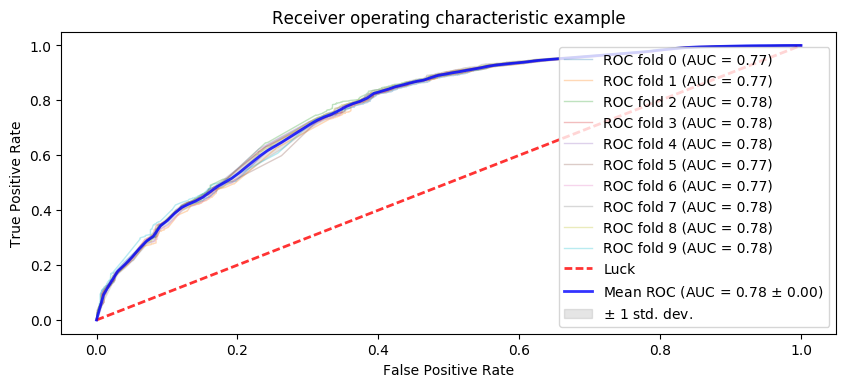

CPU times: user 20.1 s, sys: 376 ms, total: 20.5 s
Wall time: 20.1 s


In [66]:
%%time
# Trying ROC
skf = StratifiedKFold(n_splits=10)
classifier =  LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
X = cv.transform(dataset.dlls)
y = dataset.malware
plt.figure(figsize=(10, 4), dpi=100)

i = 0
for train, test in skf.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()